# 태양열 발전량 데이터 처리 및 모델 적합
---

- 데이터 처리 및 스케일링
- 모델적합

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from sol_data import X_train, y_train ,s23_test

---

---
# nbeats fitting 

In [29]:
X_train= pd.DataFrame(X_train).fillna(0)
y_train= pd.DataFrame(y_train).fillna(0)

In [19]:
X_train.shape, y_train.shape

((33817, 45), (33817, 15))

In [30]:
input_dim, output_dim =  1, 1
backcast=X_train.shape[1] # 21
forecast = y_train.shape[1] #7

K.clear_session()
model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
#model.summary()

In [31]:

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
nbeat_time1 = time.time()
history = model.fit(X_train,y_train,
                    epochs=20, batch_size=16, verbose=1,
                    callbacks=[early_stop])
nbeat_time2 = time.time()

Epoch 1/20
2114/2114 [==============================] - 11s 4ms/step - loss: 0.6694
Epoch 2/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.3121
Epoch 3/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.3059
Epoch 4/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.3013
Epoch 5/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2994
Epoch 6/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.3023
Epoch 7/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2955
Epoch 8/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2924
Epoch 9/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2909
Epoch 10/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2862
Epoch 11/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2843
Epoch 12/20
2114/2114 [==============================] - 8s 4ms/step - loss: 0.2805


In [32]:
total_training_time0 =nbeat_time2- nbeat_time1

print(f"총 학습에 걸린 시간: {total_training_time0} 초")

총 학습에 걸린 시간: 156.5660264492035 초


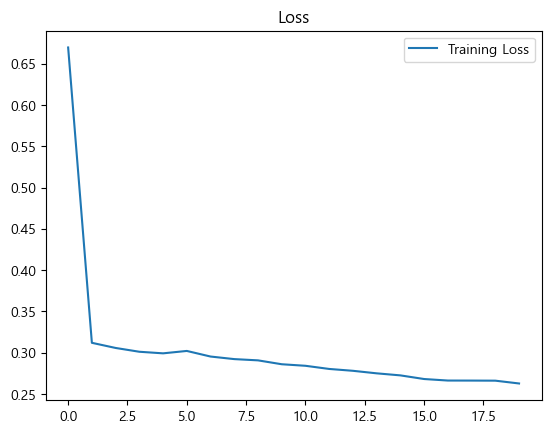

In [34]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.plot(loss,label='Training Loss')
#plt.plot(val_loss,label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

---
## 비교군1 lstm

In [35]:
from keras.layers import *
from tensorflow.keras.models import Sequential

In [39]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(128, return_sequences=False,input_shape=(45, 1)))# (timestep, feature)
modelnon0.add(Dense(15)) # output = 1
modelnon0.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

lstm_time1 = time.time()
lstm_history= modelnon0.fit(X_train,y_train, epochs=20,
          batch_size=16, verbose=0, callbacks=[early_stop])
lstm_time2 = time.time()

In [40]:
total_training_time1 =lstm_time2- lstm_time1

print(f"총 학습에 걸린 시간: {total_training_time1} 초")

총 학습에 걸린 시간: 437.73180747032166 초


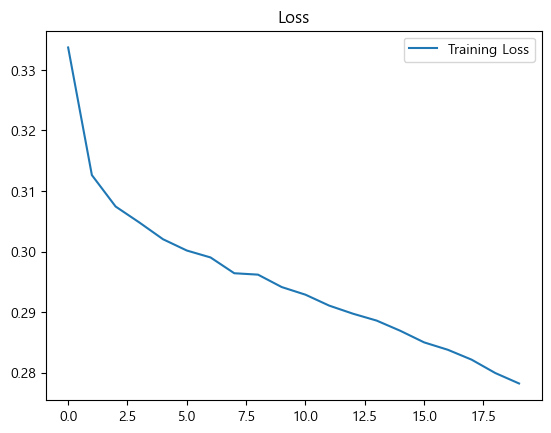

In [42]:
loss = lstm_history.history['loss']
#val_loss = lstm_history.history['val_loss']

plt.plot(loss,label='Training Loss')
#plt.plot(val_loss,label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

---
## 예측 평가

In [111]:
tx = s23_test[s23_test['지점명'] == '서울'].loc['2023-07-01 06:00':'2023-07-04 04:00'].iloc[:,1].values.reshape(1,-1)

In [112]:
ty = s23_test[s23_test['지점명'] == '서울'].loc['2023-07-05 06:00':'2023-07-06 04:00'].iloc[:,1].values.reshape(1,-1)

In [113]:
nbeat_pred = model.predict(tx)
lstm_pred = modelnon0.predict(tx)

1/1 [==============================] - 0s 16ms/step


In [114]:
np.array(ty).flatten()

array([0.  , 0.05, 0.17, 0.46, 1.72, 1.7 , 3.12, 3.15, 2.34, 2.91, 1.45,
       1.28, 1.  , 0.5 , 0.11])

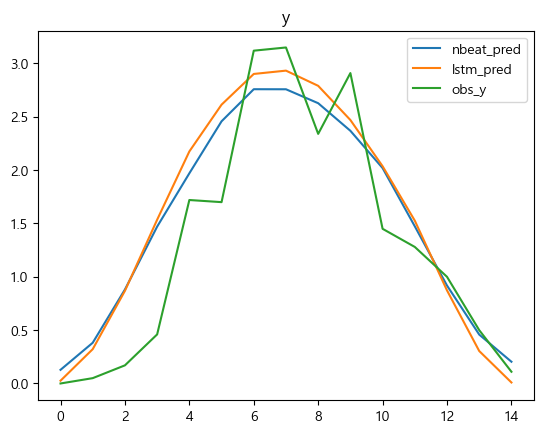

In [115]:
i=4


plt.plot(nbeat_pred.flatten() ,label='nbeat_pred')
plt.plot(lstm_pred.flatten() ,label='lstm_pred')
plt.plot(np.array(ty).flatten() ,label='obs_y')
plt.title('y')
plt.legend()
plt.show()

In [121]:
mean_squared_error(np.array(ty).flatten(),nbeat_pred.flatten())
mean_squared_error(np.array(ty).flatten(),lstm_pred.flatten())

0.24813007435137824

In [122]:
from sklearn.metrics import mean_squared_error


print(mean_squared_error(np.array(ty).flatten(),nbeat_pred.flatten())) #for i in range(len(test_y))]))
print(mean_squared_error(np.array(ty).flatten(),lstm_pred.flatten())) #for i in range(len(test_y))]))

0.22188907392726953
0.24813007435137824
